In [2]:
# a bit of setup
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import scipy.stats as stats
import utils

from sklearn.neighbors import KernelDensity
from utils import total_variation_distance

%matplotlib inline

# Gibbs Sampling #

(From wikipedia) Gibbs sampling, in its basic incarnation, is a special case of the Metropolis–Hastings algorithm.  The point of Gibbs sampling is that given a multivariate distribution it is simpler to sample from a conditional distribution than to marginalize by integrating over a joint distribution.  Suppose we want to obtain $k$ samples of $\mathbf{X} = (x_1, \dots, x_n)$ from a joint distribution $p(x_1, \dots, x_n)$.  Denote the $i$th sample by $\mathbf{X}^{(i)} = \left(x_1^{(i)}, \dots, x_n^{(i)}\right)$.  We proceed as follows:

1. We begin with some initial value $\mathbf{X}^{(i)}$.
2. We want the next sample. Call this next sample $\mathbf{X}^{(i+1)}$. Since $\mathbf{X}^{(i+1)} = \left(x_1^{(i+1)}, x_2^{(i+1)}, \dots, x_n^{(i+1)}\right)$ is a vector, we sample each component of the vector, $x_j^{(i+1)}$, from the distribution of that component conditioned on all other components sampled so far. But there is a catch: we condition on $\mathbf{X}^{(i+1)}$'s components ''up to'' $x_{j-1}^{(i+1)}$, and thereafter condition on $\mathbf{X}^{(i)}$'s components, starting from $x_{j+1}^{(i)}$ to $x_n^{(i)}$. To achieve this, we sample the components in order, starting from the first component. More formally, to sample $x_j^{(i+1)}$, we update it according to the distribution specified by $p\left(x_j^{(i+1)}|x_1^{(i+1)},\dots,x_{j-1}^{(i+1)},x_{j+1}^{(i)},\dots,x_n^{(i)}\right)$. We use the value that the $(j+1)$th component had in the $i$th sample, not the $(i+1)$th sample.
3. Repeat the above step $k$ times.

If such sampling is performed, these important facts hold:
* The samples approximate the joint distribution of all variables.
* The marginal distribution of any subset of variables can be approximated by simply considering the samples for that subset of variables, ignoring the rest.
* The expected value of any variable can be approximated by averaging over all the samples.

In [3]:
def gibbs_sampling_marginal(init_func, marginal_dists, num_iters, step=1):
    """
    Runs the metropolis-hastings algorithm for
    num_iters iterations, using proposal_func
    to generate samples and scorer to assign
    probability scores to samples.
      
    init_func -- function that proposes starting
        state; takes no arguments and returns a
        sample state
    marginal_dists -- list of the marginal densities
        functions for x_i given all other RVs
    
    Returns a sequence of every step-th sample. You 
    should only sample on upon acceptance of a new
    proposal. Do not keep sampling the current state.
    
    Note the total number of samples will NOT be
    equal to num_iters. num_iters is the total number
    of proposals we generate.
    """
    result = np.array([init_func()])
    dim = len(result[0])
    for x in range(num_iters):
        proposed = np.copy(result[-1])
        for i in range(dim):
            proposed[i] = marginal_dists[i](np.append(proposed[i+1:], proposed[:i]))
        result = np.append(result, [proposed], axis=0)
    return np.array(result[::step])

# Multivariate Gaussians #

### 2D Uncorrelated Gaussian

(129, 129, 2)


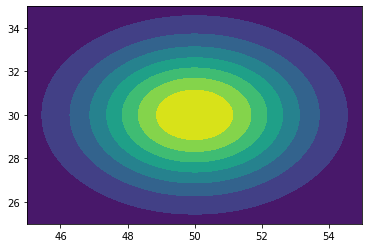

In [4]:
pdf = stats.multivariate_normal(mean=[50, 30], cov=5)
X, Y = np.mgrid[45:55:0.078, 25:35:0.078]
pos = np.dstack((X, Y))
print(pos.shape)
gauss = np.array([stats.multivariate_normal(mean=[50, 30], cov=5).pdf(x) for x in pos])
plt.contourf(X, Y, pdf.pdf(pos))
plt.show()

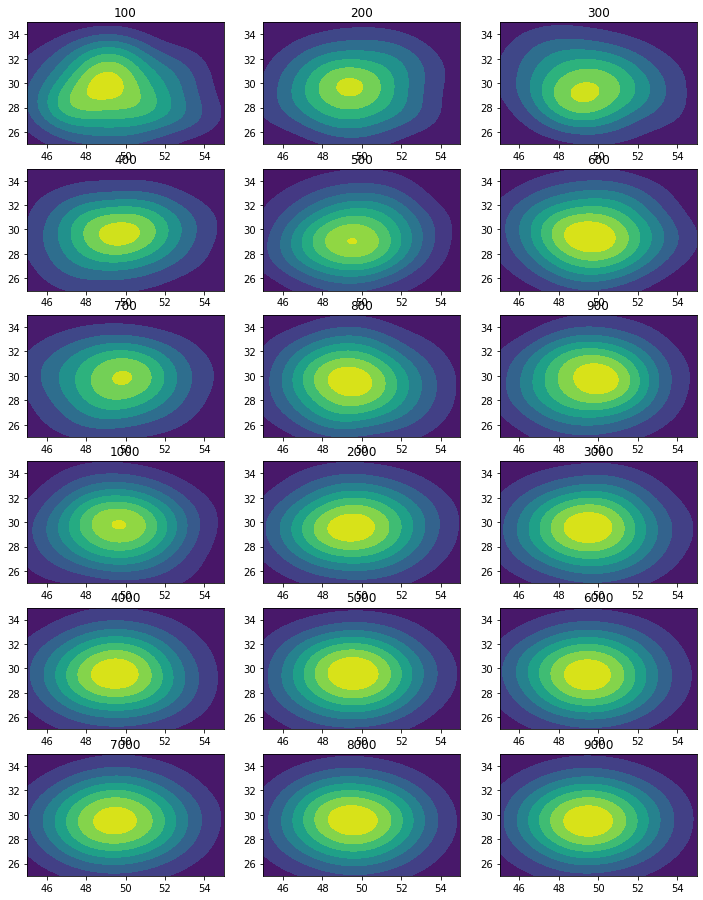

In [5]:
p1, p2 = lambda x: stats.norm(loc=50, scale=np.sqrt(5)).rvs(size=1), lambda x: stats.norm(loc=30, scale=np.sqrt(5)).rvs(size=1)
marginals = np.array([p1, p2])
init_func = lambda: np.array([50, 30])
tvd = np.array([])
plt.figure(figsize=(12,48))
for a, i in enumerate(np.append(np.arange(100, 1000, 100), np.arange(1000, 10000, 1000))):
    samples = gibbs_sampling_marginal(init_func, marginals, i)
    kde = KernelDensity(kernel='gaussian', bandwidth=1.3).fit(samples)
    estimate = np.exp(np.array([kde.score_samples(x) for x in pos]))
    tvd = np.append(tvd, total_variation_distance(estimate, gauss, 0.078))
    
    plt.subplot(18, 3, a+1)
    plt.title(i)
    plt.contourf(X, Y, estimate)
plt.show()

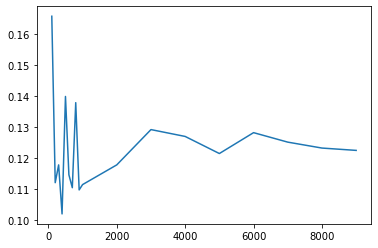

In [6]:
plt.plot(np.append(np.arange(100, 1000, 100), np.arange(1000, 10000, 1000)), tvd)
plt.show()

### 2D Correlated Jointly Gaussian ###

[[4 2]
 [2 4]]


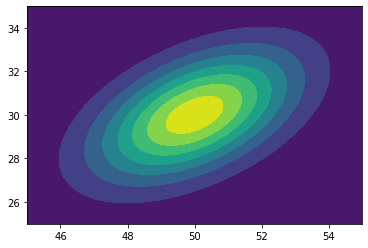

In [7]:
mu1, mu2 = 50, 30
top_half = stats.uniform(loc=0, scale=10).rvs(size=3)
# var = np.reshape(np.append(top_half[:2], [top_half[1], top_half[2]]), (2,2))
var = np.array([[4, 2], [2, 4]])
p = var[0][1] / np.sqrt(var[0][0] * var[1][1])
l0, r0 = np.sqrt(var[0][0]/var[1][1]) * p, np.sqrt( (1-p**2)*var[0][0] )
l1, r1 = np.sqrt(var[1][1]/var[0][0]) * p, np.sqrt( (1-p**2)*var[1][1] )
print(var)
pdf = stats.multivariate_normal(mean=[mu1, mu2], cov=var)
plt.contourf(X, Y, pdf.pdf(pos))
plt.show()

In [8]:
print(l0, r0, l1, r1)

0.5 1.7320508075688772 0.5 1.7320508075688772


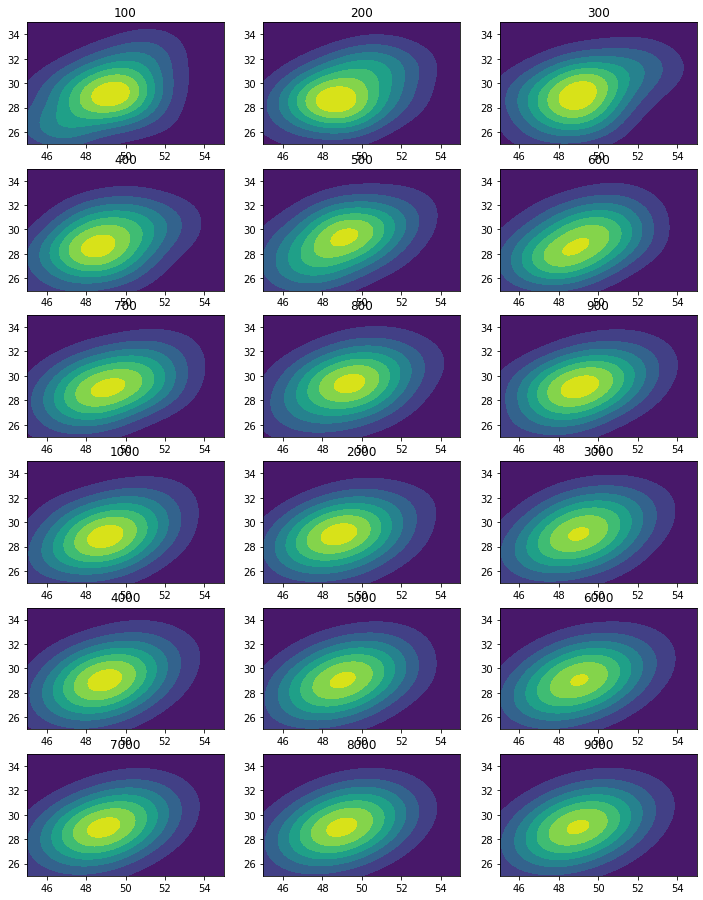

In [19]:
def p1(x, m1=mu1, m2=mu2, l=l0, r=r0):
    return stats.norm(loc=m1+l*(x[0]-m2), scale=r ).rvs(size=1)
def p2(x, m1=mu1, m2=mu2, l=l1, r=r1):
    return p1(x, m2, m1, l, r)

marginals = np.array([p1, p2])
init_func = lambda: np.array([50, 30])
tvd = np.array([])
plt.figure(figsize=(12,48))
for a, i in enumerate(np.append(np.arange(100, 1000, 100), np.arange(1000, 10000, 1000))):
    samples = gibbs_sampling_marginal(init_func, marginals, i)
    kde = KernelDensity(kernel='gaussian', bandwidth=1.3).fit(samples)
    estimate = np.exp(np.array([kde.score_samples(x) for x in pos]))
    tvd = np.append(tvd, total_variation_distance(estimate, gauss, 0.078))
    
    plt.subplot(18, 3, a+1)
    plt.title(i)
    plt.contourf(X, Y, estimate)
plt.show()

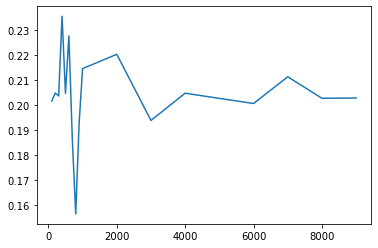

In [20]:
plt.plot(np.append(np.arange(100, 1000, 100), np.arange(1000, 10000, 1000)), tvd)
plt.show()